# OpenCV Contours 처리

Google Colab 환경에서 **OpenCV**를 사용해 **Contours(윤곽선)** 를 찾고, 다양한 정보를 추출/활용하는 방법을 다룹니다.
GUI 기반의 창을 띄울 수 없으므로, **Matplotlib**를 통해 결과 이미지를 시각화합니다.

## 주요 내용
1. Contours 찾기 및 그리기
2. 사각형 외곽(Bounding Rectangle)
3. Convex Hull
4. 유사 다각형 근사 (approxPolyDP)
5. Contours의 기본 정보 (면적, 둘레, 모멘트 등)
6. 추가 예제 (minAreaRect)
7. 과제 및 예시 답안

각 섹션별 코드와 함께 **함수별 사용법** 및 이론 설명이 포함되어 있습니다.

## 1. 라이브러리 임포트 및 헬퍼 함수
OpenCV, NumPy, Matplotlib을 임포트하고, Matplotlib으로 BGR 이미지를 시각화하기 위한 헬퍼 함수를 정의합니다.

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show_image(title, img, cmap=None):
    """
    Helper function to display an image (BGR or Grayscale) using Matplotlib.
    - If the image has 3 channels, we assume it's BGR and convert to RGB.
    - If it's 2D, we assume a grayscale image.
    """
    plt.figure(figsize=(5,5))
    if len(img.shape) == 2:
        # Grayscale
        plt.imshow(img, cmap=cmap if cmap else 'gray')
    else:
        # BGR -> RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    plt.title(title)
    plt.axis('off')
    plt.show()

## 2. Contours 기본 이론
**Contours(윤곽선)** 은 이미지에서 연속된 경계를 추적한 것으로, **물체의 외곽** 또는 **경계선**을 표현합니다.

### `cv2.findContours()`
```python
contours, hierarchy = cv2.findContours(
    image,            # 입력 이미지(이진화된 형태가 일반적)
    mode,             # 윤곽선 검색 방법 (cv2.RETR_EXTERNAL, cv2.RETR_TREE 등)
    method            # 윤곽선 근사화 방법 (cv2.CHAIN_APPROX_SIMPLE 등)
)
```
- **image**: 8비트 단일 채널(Grayscale). 일반적으로 Threshold나 Canny 에지 검출 등으로 전처리가 된 이진화 이미지.
- **mode**: 윤곽선을 찾는 방식
  - `cv2.RETR_EXTERNAL`: 가장 바깥쪽 윤곽선만 검색.
  - `cv2.RETR_TREE`: 모든 윤곽선을 검색하고, 계층 구조를 형성.
- **method**: 윤곽선 근사화 방식
  - `cv2.CHAIN_APPROX_SIMPLE`: 직선 구간은 시작점과 끝점만 저장함으로써 메모리를 절약.
  - `cv2.CHAIN_APPROX_NONE`: 모든 좌표를 저장.

결과로, `contours`는 윤곽선의 점들 좌표를 담고 있는 리스트이며, `hierarchy`는 윤곽선의 계층 구조를 담고 있는 배열입니다.

### `cv2.drawContours()`
```python
output = cv2.drawContours(
    image,     # 윤곽선을 그릴 대상 이미지(BGR 컬러)
    contours,  # 찾은 윤곽선 리스트
    contourIdx,# -1이면 모든 윤곽선을 그림
    color,     # BGR
    thickness  # 선 두께
)
```


## 3. 샘플 이미지 생성 및 Contours 찾기
아래 코드에서는 **검은색 배경(400×400) 위에 흰색 사각형**을 그려, 이진화된 이미지 형태를 인위적으로 만들어줍니다.
그 후 `cv2.findContours`를 사용하여 윤곽선을 찾고, `cv2.drawContours`로 시각화합니다.

Number of contours found: 1


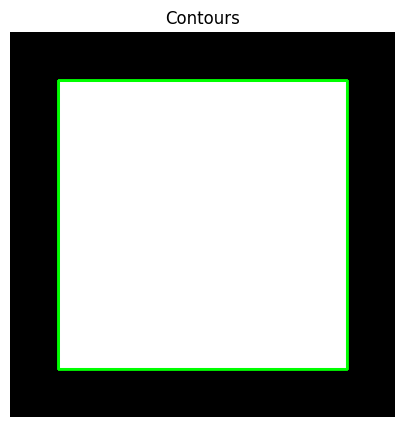

In [ ]:
# 1) Create a synthetic image (400x400, black background)
image = np.zeros((400, 400), dtype=np.uint8)  # single channel

# 2) Draw a white rectangle
cv2.rectangle(image, (50, 50), (350, 350), 255, -1)

# 3) Find contours
# Note: image must be an 8-bit single-channel binary (or thresholded) image.
contours, hierarchy = cv2.findContours(
    image.copy(),      # copy, to avoid modifying the original
    cv2.RETR_TREE,     # retrieve all contours in a tree structure
    cv2.CHAIN_APPROX_SIMPLE  # compress horizontal/vertical/diagonal segments
)

print(f"Number of contours found: {len(contours)}")

# 4) Draw contours on a BGR image for visualization
output = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # convert to 3-channel
cv2.drawContours(output, contours, -1, (0, 255, 0), 2)

show_image("Contours", output)

## 4. 사각형 외곽(Bounding Rectangle)
윤곽선으로부터 **가장 작은 (Axis-Aligned) 사각형** 영역을 구할 수 있습니다. 이 때 `cv2.boundingRect(contour)`를 사용합니다.

```python
x, y, w, h = cv2.boundingRect(contour)
```
- `(x, y)`는 사각형의 왼쪽 위 꼭짓점 좌표
- `w, h`는 사각형의 너비와 높이

직교된 사각형(Axis-Aligned Bounding Box)이므로 이미지 축에 평행합니다.

BoundingRect -> x:50, y:50, w:301, h:301


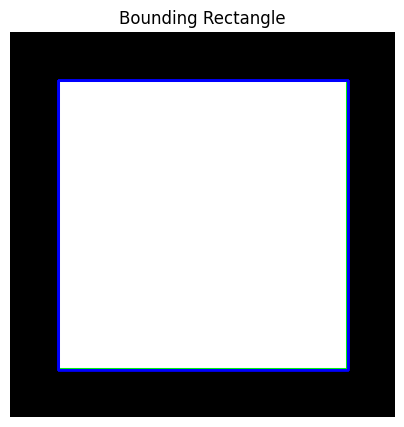

In [ ]:
# Let's use the first contour to find bounding rectangle.
contour = contours[0]  # there's likely only 1 in this synthetic image

x, y, w, h = cv2.boundingRect(contour)
print(f"BoundingRect -> x:{x}, y:{y}, w:{w}, h:{h}")

output_rect = output.copy()
cv2.rectangle(output_rect, (x, y), (x+w, y+h), (255, 0, 0), 2)

show_image("Bounding Rectangle", output_rect)

## 5. Convex Hull
윤곽선의 점들을 모두 포함하는 **볼록 다각형**(Convex Polygon) 중 가장 작은 것을 **Convex Hull**이라 합니다.

```python
hull = cv2.convexHull(contour)
```
- `hull`은 점들의 집합을 반환합니다. 이를 `drawContours`로 시각화할 수 있습니다.

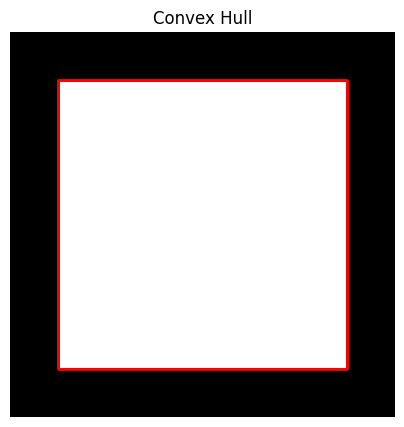

In [ ]:
# Calculate Convex Hull
hull = cv2.convexHull(contour)

# Draw it in red
output_hull = output.copy()
cv2.drawContours(output_hull, [hull], -1, (0, 0, 255), 2)

show_image("Convex Hull", output_hull)

## 6. 유사 다각형 근사 (Polygon Approximation)
**`cv2.approxPolyDP()`** 함수는 더 적은 점으로 윤곽선을 근사화합니다.
특히, 윤곽선의 **직선 구간**이 많은 경우 점을 크게 줄여 효율적인 표현이 가능합니다.

```python
approx = cv2.approxPolyDP(contour, epsilon, closed)
```
- **`epsilon`**: 근사 오차(정밀도) 파라미터. `epsilon`이 클수록 점이 더 많이 생략됩니다.
- **`closed`**: 윤곽선이 닫혀있는지 여부 (True/False)

아래 예시에서는 윤곽선의 둘레(`arcLength`)에 비례한 `epsilon` 값을 사용합니다.

Number of points in original contour: 4
Number of points in approximated polygon: 4


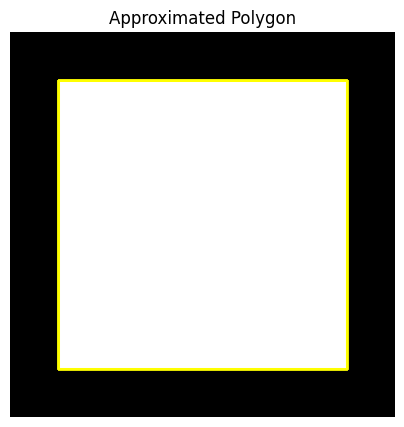

In [ ]:
# Approximate the contour to a polygon
epsilon = 0.02 * cv2.arcLength(contour, True)  # 2% of the contour perimeter
approx = cv2.approxPolyDP(contour, epsilon, True)

print("Number of points in original contour:", len(contour))
print("Number of points in approximated polygon:", len(approx))

# Draw the approximated polygon in yellow
output_approx = output.copy()
cv2.drawContours(output_approx, [approx], -1, (0, 255, 255), 2)

show_image("Approximated Polygon", output_approx)

## 7. Contours의 기본 정보
윤곽선(Contour)에 대해 다양한 속성을 계산할 수 있습니다.

1. **면적(Area)**: `cv2.contourArea(contour)`
2. **둘레(Perimeter)**: `cv2.arcLength(contour, closed=True)`
3. **모멘트(Moments)**: `cv2.moments(contour)`
   - 질량중심(centroid) 등을 구하는데 사용할 수 있습니다.
   - `M = cv2.moments(contour)`라 하면,
     - `cx = M['m10']/M['m00']`
     - `cy = M['m01']/M['m00']` 를 통해 무게중심 (centroid)을 계산.


In [ ]:
# Contour basic info
area = cv2.contourArea(contour)
perimeter = cv2.arcLength(contour, True)
moments = cv2.moments(contour)

print("Contour Area:", area)
print("Contour Perimeter:", perimeter)
print("Moments:", moments)

# Calculate centroid using moments
if moments['m00'] != 0:
    cx = int(moments['m10'] / moments['m00'])
    cy = int(moments['m01'] / moments['m00'])
    print(f"Centroid: ({cx}, {cy})")
else:
    print("Contour area is zero, cannot compute centroid.")

Contour Area: 90000.0
Contour Perimeter: 1200.0
Moments: {'m00': 90000.0, 'm10': 18000000.0, 'm01': 18000000.0, 'm20': 4275000000.0, 'm11': 3600000000.0, 'm02': 4275000000.0, 'm30': 1125000000000.0, 'm21': 855000000000.0, 'm12': 855000000000.0, 'm03': 1125000000000.0, 'mu20': 675000000.0, 'mu11': 0.0, 'mu02': 675000000.0, 'mu30': 0.0, 'mu21': 0.0, 'mu12': 0.0, 'mu03': 0.0, 'nu20': 0.08333333333333334, 'nu11': 0.0, 'nu02': 0.08333333333333334, 'nu30': 0.0, 'nu21': 0.0, 'nu12': 0.0, 'nu03': 0.0}
Centroid: (200, 200)


## 8. (추가 예제) `minAreaRect`
Contours에서 **기울어진 직사각형**(Rotated Rectangle)을 구하는 함수입니다.
보통 BoundingRect는 축에 평행한 직사각형을 구하지만, `minAreaRect`는 **회전된** 직사각형 중 면적이 가장 작은 것을 찾습니다.

```python
rect = cv2.minAreaRect(contour)
box = cv2.boxPoints(rect)
box = np.int0(box)
```
- `rect`는 ( (cx, cy), (width, height), angle ) 형태로 반환.
- `cv2.boxPoints(rect)`를 이용해 사각형 4점의 좌표를 얻을 수 있습니다.

minAreaRect -> ((200.0, 200.0), (300.0, 300.0), 90.0)
Box points: [[ 50  50]
 [350  50]
 [350 350]
 [ 50 350]]


<ipython-input-7-67b5153d72bd>:4: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  box_points = np.int0(box_points)


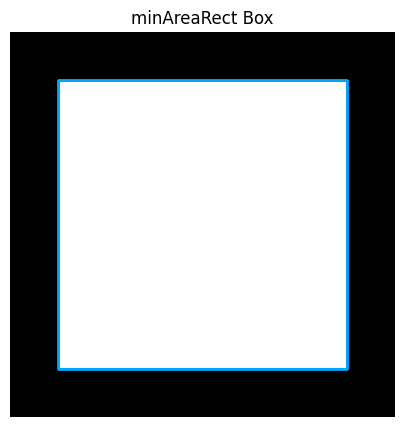

In [ ]:
# Demonstrate minAreaRect
rotated_rect = cv2.minAreaRect(contour)  # ((cx, cy), (w, h), angle)
box_points = cv2.boxPoints(rotated_rect)  # 4 corner points
box_points = np.int0(box_points)

print("minAreaRect ->", rotated_rect)
print("Box points:", box_points)

output_minarea = output.copy()
cv2.drawContours(output_minarea, [box_points], -1, (255, 165, 0), 2)

show_image("minAreaRect Box", output_minarea)

# 9. 과제
아래는 Contours 관련 **추가 실습** 아이디어입니다. 노트북 맨 아래 셀에 **예시 코드**를 간단히 제공해 두었습니다.

1. **다중 객체 이미지**에서의 Contours 처리
   - 여러 개의 도형(원, 사각형 등)을 그린 이미지를 만들고, 윤곽선을 찾아서 각각에 대한 bounding box, convex hull 등을 시도해 보세요.
2. **Contour 정렬**
   - 다중 윤곽선을 찾은 뒤, x좌표나 면적 등을 기준으로 정렬하여 나열해 보세요.
3. **실제 이미지 사용**
   - Threshold, Canny 에지 검출 등을 적용하여 Contours를 찾고, 물체 외곽을 탐지해 보세요.
4. **자세한 계층 구조(hierarchy)** 분석
   - `hierarchy`를 이용해 부모-자식 윤곽선을 구분하는 로직을 작성해 보세요.
5. **직사각형으로 잘라내기**
   - `boundingRect` 결과를 이용해 이미지의 ROI를 잘라 저장하거나 시각화.


## 9.1 과제 예시 코드
예시로, **다중 객체**(사각형 2개, 원 1개)를 그린 이미지를 생성해 윤곽선을 찾고, 각 윤곽선에 대해서 면적과 boundingRect를 표시하는 간단한 코드를 첨부합니다.

Number of contours found: 3


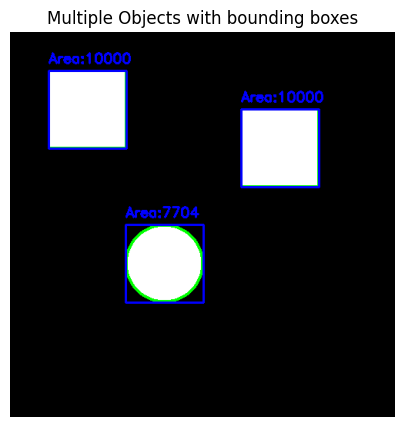

In [ ]:
# (과제 1) Multiple objects and bounding boxes

# 1) Create a black image (500x500)
multi_img = np.zeros((500, 500), dtype=np.uint8)

# 2) Draw multiple shapes (two rectangles, one circle)
cv2.rectangle(multi_img, (50, 50), (150, 150), 255, -1)
cv2.rectangle(multi_img, (300, 100), (400, 200), 255, -1)
cv2.circle(multi_img, (200, 300), 50, 255, -1)

# 3) Find contours
contours_multi, hierarchy_multi = cv2.findContours(multi_img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
print(f"Number of contours found: {len(contours_multi)}")

# 4) Convert to BGR for drawing
multi_output = cv2.cvtColor(multi_img, cv2.COLOR_GRAY2BGR)
cv2.drawContours(multi_output, contours_multi, -1, (0, 255, 0), 2)

for i, cnt in enumerate(contours_multi):
    # Calculate area
    area_ = cv2.contourArea(cnt)
    x_, y_, w_, h_ = cv2.boundingRect(cnt)

    # Draw bounding rectangle
    cv2.rectangle(multi_output, (x_, y_), (x_+w_, y_+h_), (255, 0, 0), 2)
    # Put text (area) on the image
    cv2.putText(multi_output, f"Area:{int(area_)}", (x_, y_-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

show_image("Multiple Objects with bounding boxes", multi_output)

위 예시는 윤곽선의 개수에 따라 반복문을 돌며, 각 윤곽선에 대한 **면적**과 **boundingRect**를 계산하고 시각화합니다.
이처럼 여러 도형 혹은 실제 사진에서 추출된 다중 윤곽선을 처리할 때, 개별 윤곽선별 정보(면적, 위치, 컨벡스헐, 최소 외접 사각형 등)를 활용할 수 있습니다.

# 10. 참고 자료
- [OpenCV 공식 문서](https://docs.opencv.org/4.x/): Contours, Hierarchy, Moments 등 함수 설명.
- [LearnOpenCV](https://learnopencv.com/): OpenCV 관련 심화 튜토리얼.

다양한 이미지에 `findContours()`를 적용하고, 객체 인식·트래킹 등에 응용해 보세요!